In [1]:
%load_ext autoreload
%autoreload 2
%aimport -decode_fish.engine.place_psfs

In [2]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *

from numba import njit
from scipy.spatial import cKDTree
from decode_fish.funcs.evaluation import *

import io, requests, glob

from decode_fish.funcs.merfish_eval import *
from decode_fish.funcs.exp_specific import *
# from starfish import data
import pprint
import seaborn as sns

import plotly.express as px
import plotly.io as pio
pio.renderers.default='notebook'

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [183]:
bench_df = get_mop_benchmark()
codebook, targets = get_mop_codebook()

17130008


In [5]:
max_p_150 = cpu(read_MOp_tiff(base_path+'/datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_images150.tif', scaled=True, z_to_batch=True)).max(0).max(0)[0]
max_p_151 = cpu(read_MOp_tiff(base_path+'/datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_images151.tif', scaled=True, z_to_batch=True)).max(0).max(0)[0]
max_p_47 = cpu(read_MOp_tiff(base_path+'/datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_images47.tif', scaled=True, z_to_batch=True)).max(0).max(0)[0]

In [6]:
fids_150 = get_peaks(max_p_150, 18000, 20)
fids_151 = get_peaks(max_p_151, 18000, 20)
fids_47 = get_peaks(max_p_47, 18000, 20)

In [156]:
!rm -r '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/sweep_mop_27/base'

In [344]:
select = ['base']#,'bs:20xcrop_sz:56xbl_loss_scale:0.003','crop_sz:56','bs:15','bs:20']

sweep_name = 'sweep_mop_28'
file_nrs = [150,151,47]

out_dir = f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/{sweep_name}/*'
files = glob.glob(out_dir)
base_str = 'bsub -gpu "num=1" -q gpu_rtx -n 3 -o logs/ofish.log -e logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/merfish_eval.py '

with open('run_slurm.sh', 'w') as f:
    for nr in file_nrs:
        for n in files:
            if '' in n:
                name = n.split('/')[-1]
                if 'step' not in name:
                    print(name)
                    f.write(base_str + f'run_name={name} sweep_name={sweep_name} file_nr={nr} \n')
#                     print(base_str + f'run_name={name} sweep_name={sweep_name} file_nr={nr} \n')

sc_3000
base
pos05
est_ch_facs
np_emnp
no_foci
const_theta
sc_3000
base
pos05
est_ch_facs
np_emnp
no_foci
const_theta
sc_3000
base
pos05
est_ch_facs
np_emnp
no_foci
const_theta


In [133]:
def clean_bench_df(bench_df, fids=None):
    bench_df = nm_to_px((bench_df), [1.085,1.085,1.085])
    bench_df['x'] += 70
    bench_df['y'] += 70
    bench_df = exclude_borders(bench_df, border_size_zyx=[0,15000,15000], img_size=[2048*100,2048*100,2048*100])
    bench_df = remove_fids(bench_df, px_to_nm(fids), tolerance=1000)
    bench_df = remove_doublets(bench_df, tolerance=200)
    bench_df['class'] = bench_df['gene'].str.contains('Blank')
    return bench_df

def clean_istd_df(bench_df, fids=None):
    bench_df['loc_idx'] = np.arange(len(bench_df))
    bench_df['gene'] = targets[bench_df['code_inds']]
    bench_df = exclude_borders(bench_df, border_size_zyx=[0,15000,15000], img_size=[2048*100,2048*100,2048*100])
    bench_df = remove_fids(bench_df, px_to_nm(fids), tolerance=1000)
    bench_df = remove_doublets(bench_df, tolerance=200)
    bench_df['class'] = bench_df['gene'].str.contains('Blank')
    return bench_df

def log_reg(df, weights={}):
    
    df = df.copy()
    df['score'] = 0
    for k in weights:
        df['score'] += weights[k] * df[k]
    df['score'] = 1/(1 + np.exp(-df['score']))
    return df

In [9]:
istd_151 = pd.read_csv('../data/results/MERFISH/istdeco_MOp_151.csv')

In [10]:
istd_151 = clean_istd_df(istd_151, fids_151)

/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/funcs/emitter_io.py:223: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_17135/491749581.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:
# bench_df, code_ref, targets = get_merfish_mop(return_bench_df=True, z_to_batch=True)
bench_150 = clean_bench_df(get_mop_fov(bench_df, 150), fids_150)
bench_151 = clean_bench_df(get_mop_fov(bench_df, 151), fids_151)
bench_47 = clean_bench_df(get_mop_fov(bench_df, 47), fids_47)

/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/funcs/emitter_io.py:223: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_17135/491749581.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/funcs/emitter_io.py:223: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [191]:
logr_coefs = {'x_sig': 0.03, 'y_sig': 0.03, 'z_sig': 0.0, 'prob': -2.3}

In [358]:
df_dict = {'150':{},'151':{},'47':{}}

sweep_name = 'merfish_sweep_mop_28'

for f in glob.glob(f'../data/results/MERFISH/{sweep_name}_*.csv'):
    if '' in f:
        dec_df = pd.read_csv(f)
        
        if len(dec_df) > 1000:

            if '_47' in f:
                ds = '47'
            if '_150' in f:
                ds = '150'
            if '_151' in f:
                ds = '151'

#             dec_df = remove_doublets(dec_df, tolerance=200)
#             inp = input_from_df(dec_df, codebook)
#             dec_df['net_score'] = cpu(net(inp))
#             inp[:,:27] *= 0
#             dec_df['net_score2'] = cpu(net(inp))
#             dec_df = sel_int_ch(dec_df, codebook)

            sel = dec_df['code_inds']<len(codebook)
            print(f, sum(sel))
            dec_df = dec_df[sel]
            dec_df['gene'] = 'single'
            dec_df.loc[sel,'gene'] = targets[dec_df.loc[sel,'code_inds']]
            dec_df = log_reg(dec_df, logr_coefs)
            dec_df['class'] = dec_df['gene'].str.contains('Blank').values * 1 
#             dec_df.loc[~sel,'class'] = 2
            
#             dec_df['net_score'] = cpu(tra(input_from_df(dec_df)))
            df_dict[ds][f.split(sweep_name)[-1].split('.csv')[0].split('_None')[0]] = dec_df

../data/results/MERFISH/merfish_sweep_mop_28_est_ch_facs_None_151.csv 48660
../data/results/MERFISH/merfish_sweep_mop_28_base_None_150.csv 39590
../data/results/MERFISH/merfish_sweep_mop_28_np_emnp_None_47.csv 116107
../data/results/MERFISH/merfish_sweep_mop_28_sc_3000_None_47.csv 92859
../data/results/MERFISH/merfish_sweep_mop_28_np_emnp_None_151.csv 58127
../data/results/MERFISH/merfish_sweep_mop_28_est_ch_facs_None_47.csv 93629
../data/results/MERFISH/merfish_sweep_mop_28_est_ch_facs_None_150.csv 37988
../data/results/MERFISH/merfish_sweep_mop_28_no_foci_None_47.csv 113247
../data/results/MERFISH/merfish_sweep_mop_28_pos05_None_151.csv 52084
../data/results/MERFISH/merfish_sweep_mop_28_base_None_47.csv 99862
../data/results/MERFISH/merfish_sweep_mop_28_pos05_None_47.csv 100628
../data/results/MERFISH/merfish_sweep_mop_28_const_theta_None_150.csv 39335
../data/results/MERFISH/merfish_sweep_mop_28_const_theta_None_47.csv 94454
../data/results/MERFISH/merfish_sweep_mop_28_sc_3000_None_

In [359]:
names = [k for k in df_dict['151'].keys()]
# del(names[2])
omega_df = DF(columns=pd.MultiIndex.from_product([['150','151','47'], names+['bench']]), index=['N','N_blanks', 'NN_blanks', 'int_sig'])
for d, bm in zip(['150','151','47'], [bench_150,bench_151,bench_47]):
    omega_df.loc['N', d]['bench'] = len(bm)
    omega_df.loc['N_blanks', d]['bench'] = sum(bm['gene'].str.contains('Blank'))
    omega_df.loc['NN_blanks', d]['bench'] = 1.

for n in ['150','151','47']:
    for j in names:
#         if j+f'_{n}' in df_dict[n]:
        if j in df_dict[n]:
            exp_df = df_dict[n][j]
#             logr_coefs = {'x_sig': 0.03, 'y_sig': 0.03, 'z_sig': 0.0, 'prob': -2.3, 'int_ratio':2.}
            exp_df = log_reg(exp_df, logr_coefs)
            
            int_arr = zero_int_ch(exp_df.nsmallest(omega_df.loc['N', n]['bench'],'score'), codebook)[[f'int_{i}' for i in range(codebook.shape[1])]].values
            ch_means = [int_arr[:,i].sum()/(int_arr[:,i] != 0).sum() for i in range(22)]
            omega_df.loc['int_sig', n][j] = np.sqrt(np.var(ch_means))
            
            exp_df = sel_int_ch(exp_df, codebook)
            
            omega_df.loc['N', n][j] = len(exp_df)
            omega_df.loc['N_blanks', n][j] = sum(exp_df['gene'].str.contains('Blank'))
            if len(exp_df) > omega_df.loc['N', n]['bench']:
                omega_df.loc['NN_blanks', n][j] = sum(exp_df.nsmallest(omega_df.loc['N', n]['bench'], 'int_ratio')['gene'].str.contains('Blank'))/omega_df.loc['N_blanks', n]['bench']
            else:
                omega_df.loc['NN_blanks', n][j] = None
                
            
#             print(f'{j} not in {n}')

In [360]:
omega_df

150                                                    \
          _est_ch_facs  _np_emnp    _pos05  _sc_3000     _base  _no_foci   
N                37988     45484     40595     38728     39590     44183   
N_blanks           179       309       262       191       194       296   
NN_blanks     0.577778  0.644444       0.8  0.511111  0.311111  0.333333   
int_sig       0.167502  0.182152  0.247676  0.161882  0.177544  0.160745   

                                       151            ...                      \
          _const_theta  bench _est_ch_facs  _np_emnp  ... _const_theta  bench   
N                39335  28654        48660     58127  ...        50841  36405   
N_blanks           186     45          210       340  ...          227     57   
NN_blanks     0.511111    1.0     0.403509  0.245614  ...     0.245614    1.0   
int_sig       0.168342    NaN     0.181803   0.22086  ...     0.175139    NaN   

                    47                                                    \
          _est_ch_facs  _np_emnp    _pos05  _sc_3000     _base  _no_foci   
N                93629    116107    100628     92859     99862    113247   
N_blanks           461       773       874       453       507       943   
NN_blanks     0.272727  0.465909  0.602273  0.306818  0.215909  0.136364   
int_sig       0.095984   0.20572  0.206794  0.146403  0.102896  0.131902   

                               
          _const_theta  bench  
N                94454  63950  
N_blanks           481     88  
NN_blanks     0.306818    1.0  
int_sig       0.082698    NaN  

[4 rows x 24 columns]

<AxesSubplot:>

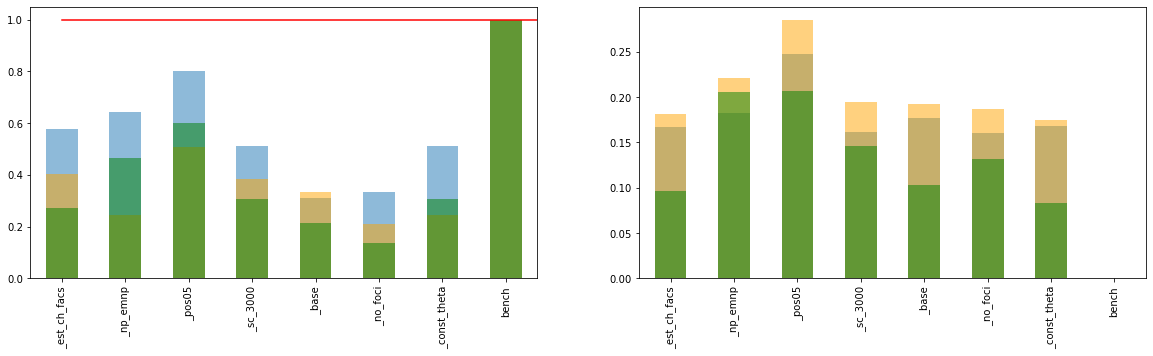

In [361]:
plt.figure(figsize=(20,5))
plt.subplot(121)
omega_df.loc['NN_blanks','150'].plot.bar(alpha =0.5)
omega_df.loc['NN_blanks','151'].plot.bar(alpha =0.5, color='orange')
omega_df.loc['NN_blanks','47'].plot.bar(alpha =0.5, color='green')
plt.plot([0,len(omega_df.columns)/2],[1,1], color='red')
plt.subplot(122)
omega_df.loc['int_sig','150'].plot.bar(alpha =0.5)
omega_df.loc['int_sig','151'].plot.bar(alpha =0.5, color='orange')
omega_df.loc['int_sig','47'].plot.bar(alpha =0.5, color='green')

<AxesSubplot:>

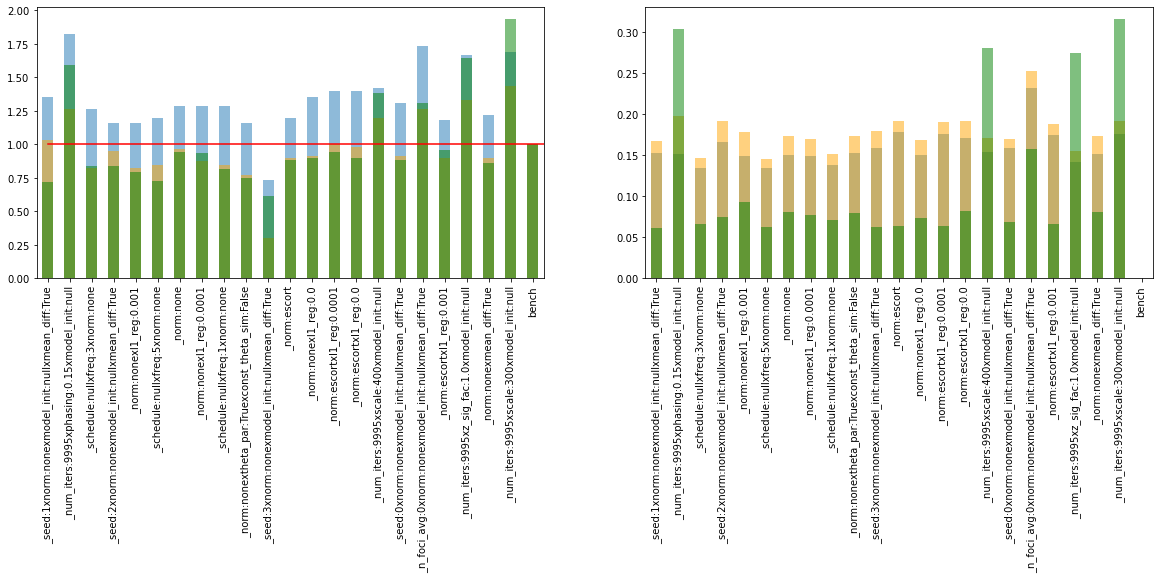

In [336]:
plt.figure(figsize=(20,5))
plt.subplot(121)
omega_df.loc['NN_blanks','150'].plot.bar(alpha =0.5)
omega_df.loc['NN_blanks','151'].plot.bar(alpha =0.5, color='orange')
omega_df.loc['NN_blanks','47'].plot.bar(alpha =0.5, color='green')
plt.plot([0,len(omega_df.columns)/2],[1,1], color='red')
# plt.ylim(0,1)
plt.subplot(122)
omega_df.loc['int_sig','150'].plot.bar(alpha =0.5)
omega_df.loc['int_sig','151'].plot.bar(alpha =0.5, color='orange')
omega_df.loc['int_sig','47'].plot.bar(alpha =0.5, color='green')

<AxesSubplot:>

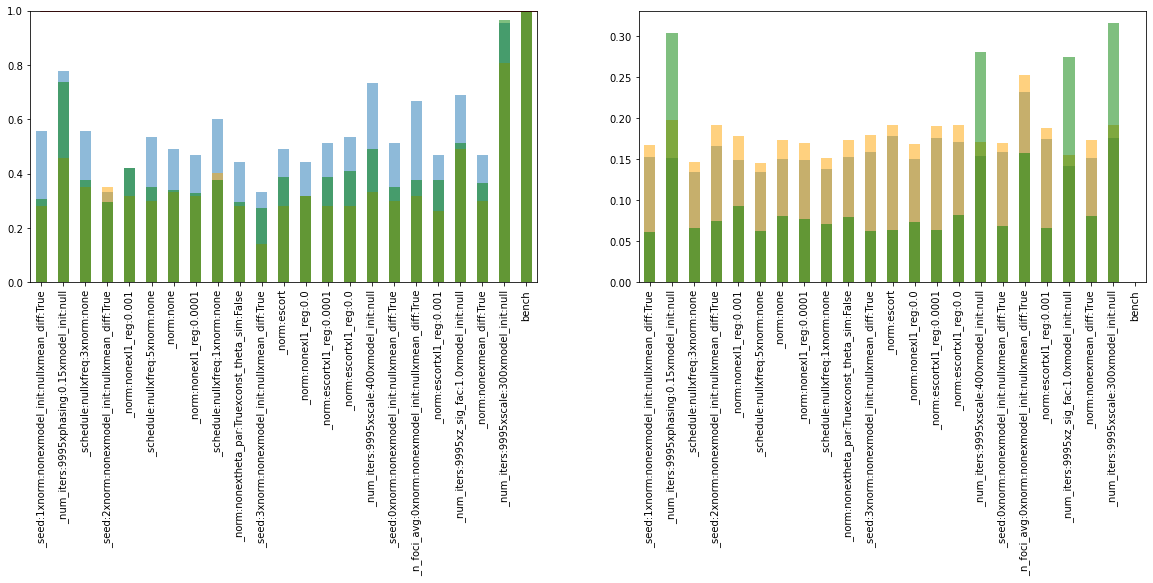

In [287]:
plt.figure(figsize=(20,5))
plt.subplot(121)
omega_df.loc['NN_blanks','150'].plot.bar(alpha =0.5)
omega_df.loc['NN_blanks','151'].plot.bar(alpha =0.5, color='orange')
omega_df.loc['NN_blanks','47'].plot.bar(alpha =0.5, color='green')
plt.plot([0,len(omega_df.columns)/2],[1,1], color='red')
plt.ylim(0,1)
plt.subplot(122)
omega_df.loc['int_sig','150'].plot.bar(alpha =0.5)
omega_df.loc['int_sig','151'].plot.bar(alpha =0.5, color='orange')
omega_df.loc['int_sig','47'].plot.bar(alpha =0.5, color='green')

<AxesSubplot:>

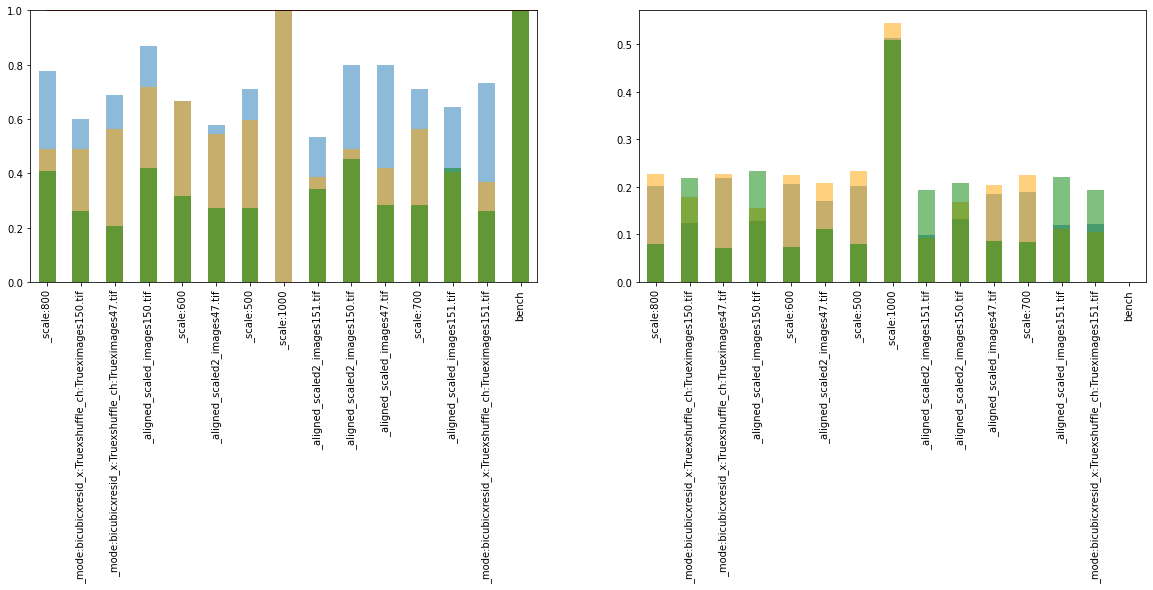

In [281]:
plt.figure(figsize=(20,5))
plt.subplot(121)
omega_df.loc['NN_blanks','150'].plot.bar(alpha =0.5)
omega_df.loc['NN_blanks','151'].plot.bar(alpha =0.5, color='orange')
omega_df.loc['NN_blanks','47'].plot.bar(alpha =0.5, color='green')
plt.plot([0,len(omega_df.columns)/2],[1,1], color='red')
plt.ylim(0,1)
plt.subplot(122)
omega_df.loc['int_sig','150'].plot.bar(alpha =0.5)
omega_df.loc['int_sig','151'].plot.bar(alpha =0.5, color='orange')
omega_df.loc['int_sig','47'].plot.bar(alpha =0.5, color='green')

<AxesSubplot:>

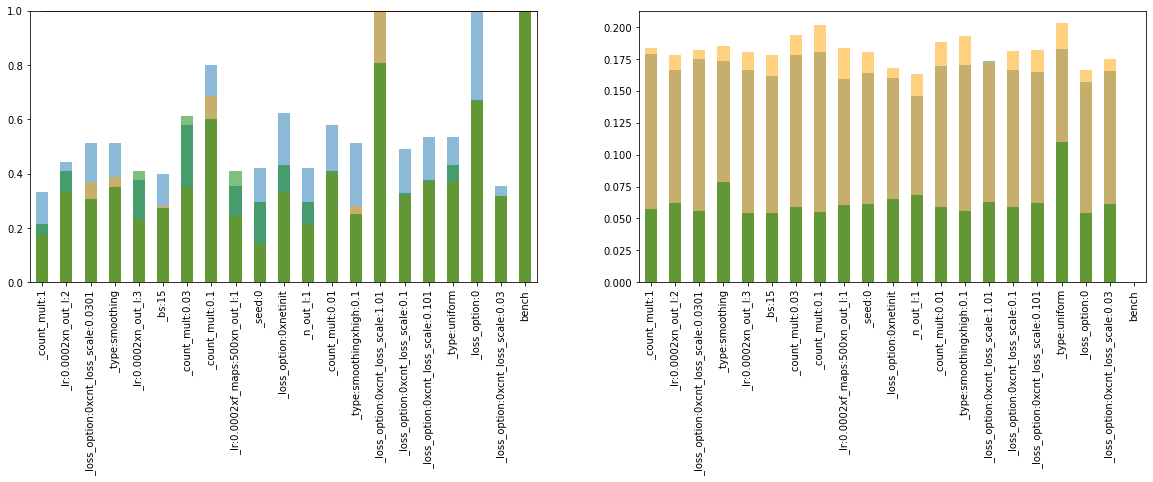

In [284]:
plt.figure(figsize=(20,5))
plt.subplot(121)
omega_df.loc['NN_blanks','150'].plot.bar(alpha =0.5)
omega_df.loc['NN_blanks','151'].plot.bar(alpha =0.5, color='orange')
omega_df.loc['NN_blanks','47'].plot.bar(alpha =0.5, color='green')
plt.plot([0,len(omega_df.columns)/2],[1,1], color='red')
plt.ylim(0,1)
plt.subplot(122)
omega_df.loc['int_sig','150'].plot.bar(alpha =0.5)
omega_df.loc['int_sig','151'].plot.bar(alpha =0.5, color='orange')
omega_df.loc['int_sig','47'].plot.bar(alpha =0.5, color='green')

In [222]:
df_dict['47'].keys()

dict_keys(['_lr:0.0002xpos_noise_xy:0.3xint_loc:1.0', '_lr:0.0002xpos_noise_xy:0.3xint_loc:2.0', '_lr:0.0002', '_lr:0.0002xpos_noise_xy:0.3xint_loc:3.0', '_lr:0.0001', '_lr:0.0002xpos_noise_xy:0.3'])

In [362]:
res_df1 = df_dict['150']['_no_foci']
# res_df2 = df_dict['150']['_lr:0.0002xpos_noise_xy:0.3']
# res_df2r = df_dictr['151']['_seed:1xnorm:nonexmodel_init:nullxmean_diff:True']

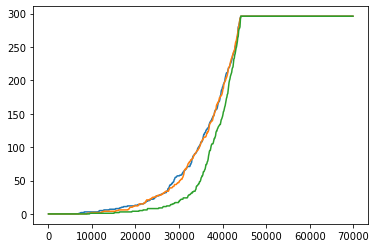

In [363]:
res_df1['class'] = res_df1['gene'].str.contains('Blank')
res_df1 = sel_int_ch(res_df1, codebook)
for k in ['comb_sig','score','int_ratio']:
    r  = make_roc(res_df1, k, n_max=70000, ascending=True)
    plt.plot(r[0],r[1], label=k)
    
# res_df2['class'] = res_df2['gene'].str.contains('Blank')
# res_df2 = sel_int_ch(res_df2, codebook)
# for k in ['comb_sig','score','int_ratio']:
#     r  = make_roc(res_df2, k, n_max=70000, ascending=True)
#     plt.plot(r[0],r[1], label=k)
# plt.legend()

28654 29000


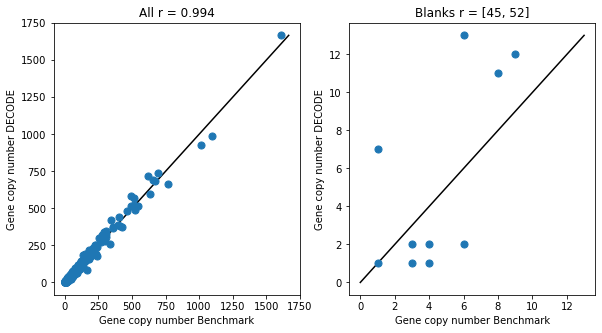

In [364]:
plot_gene_panels(res_df1.nsmallest(29000, 'comb_sig'), bench_150, targets)

28654 29000


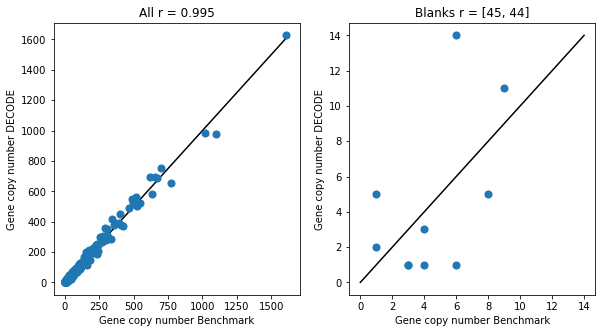

In [366]:
plot_gene_panels(res_df1.nsmallest(29000, 'score'), bench_150, targets)

In [320]:
_,matches,shift = matching(bench_150, res_df1.nsmallest(29000, 'comb_sig'), tolerance=500, print_res=True, allow_multiple_matches=False)

Recall: 0.717
Precision: 0.708
Jaccard: 55.318
RMSE_vol: 78.489
Eff_3d: 40.531
FN: 8120.0 FP: 8466.0
Num. matches: 20534.000
Shift: 0.51,3.08,-42.18


In [254]:
_,matches,shift = matching(bench_150, res_df2.nsmallest(29000, 'comb_sig'), tolerance=500, print_res=True, allow_multiple_matches=False)

Recall: 0.663
Precision: 0.655
Jaccard: 49.166
RMSE_vol: 64.478
Eff_3d: 39.805
FN: 9651.0 FP: 9997.0
Num. matches: 19003.000
Shift: 0.34,0.27,-3.82


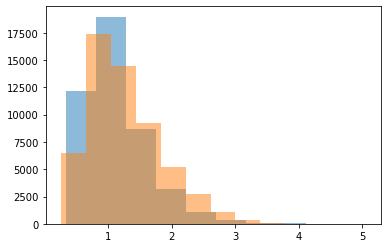

In [272]:
_ =plt.hist(res_df1['int_ratio'], alpha=0.5)
_ =plt.hist(res_df2['int_ratio'], alpha=0.5)

In [851]:
_,matches,shift = matching(istd_151.nlargest(50000, 'quality'), res_df.nsmallest(50000, 'score'), tolerance=500, print_res=True, allow_multiple_matches=False)

Recall: 0.002
Precision: 0.002
Jaccard: 0.109
RMSE_vol: 352.061
Eff_3d: -102.398
FN: 49891.0 FP: 49891.0
Num. matches: 109.000
Shift: -1.41,-14.39,1.20


In [253]:
_,matches,shift = matching(res_df1, res_df2, tolerance=500, print_res=True, allow_multiple_matches=False)

Recall: 0.754
Precision: 0.817
Jaccard: 64.495
RMSE_vol: 38.462
Eff_3d: 59.621
FN: 25547.0 FP: 17476.0
Num. matches: 78150.000
Shift: -0.23,0.24,1.87


In [256]:
matches.keys()

Index(['loc_idx_tar', 'frame_idx_tar', 'code_inds_tar', 'x_tar', 'y_tar',
       'z_tar', 'prob_tar', 'x_sig_tar', 'y_sig_tar', 'z_sig_tar',
       ...
       'int_19_pred', 'int_sig_19_pred', 'int_20_pred', 'int_sig_20_pred',
       'int_21_pred', 'int_sig_21_pred', 'gene_pred', 'zm_pred', 'score_pred',
       'class_pred'],
      dtype='object', length=118)

In [215]:
int_ks = [f'int_{i}' for i in range(22)]
intarr1 = matches[[f'int_{i}_tar' for i in range(22)]].values
intarr2 = matches[[f'int_{i}_pred' for i in range(22)]].values

for i in range(50):
    plt.plot(intarr1[i])
    plt.plot(intarr2[i])
    plt.show()
    

KeyError: "None of [Index(['int_0_tar', 'int_1_tar', 'int_2_tar', 'int_3_tar', 'int_4_tar',\n       'int_5_tar', 'int_6_tar', 'int_7_tar', 'int_8_tar', 'int_9_tar',\n       'int_10_tar', 'int_11_tar', 'int_12_tar', 'int_13_tar', 'int_14_tar',\n       'int_15_tar', 'int_16_tar', 'int_17_tar', 'int_18_tar', 'int_19_tar',\n       'int_20_tar', 'int_21_tar'],\n      dtype='object')] are in the [columns]"

0.9141224288357411

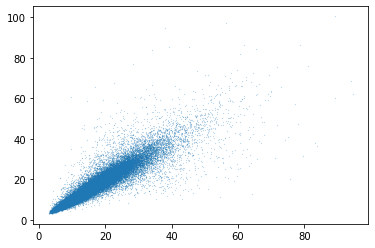

In [1398]:
plt.scatter(matches['x_sig_pred'], matches['x_sig_tar'], s=0.01)
np.corrcoef(np.array(matches['x_sig_pred'], dtype=np.float32), np.array(matches['x_sig_tar'], dtype=np.float32))[0,1]

In [1542]:
res_dfc2 = DF()
for k in res_df2r.columns:
    try:
        res_dfc2[k] = np.array(matches[k+'_pred'].values, dtype=np.float32)
    except ValueError:
        res_dfc2[k] = np.array(matches[k+'_pred'].values)

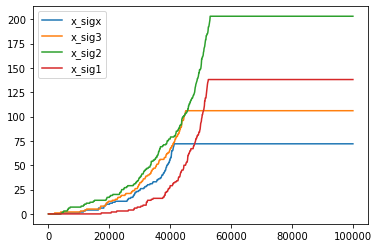

In [1543]:
for k in ['x_sig']:
    r  = make_roc(res_dfc2, k, n_max=100000, ascending=True)
    plt.plot(r[0],r[1], label=k+'x')
    r  = make_roc(res_df2r, k, n_max=100000, ascending=True)
    plt.plot(r[0],r[1], label=k+'3')
    r  = make_roc(res_df2, k, n_max=100000, ascending=True)
    plt.plot(r[0],r[1], label=k+'2')
    r  = make_roc(res_df1, k, n_max=100000, ascending=True)
    plt.plot(r[0],r[1], label=k+'1')
plt.legend()

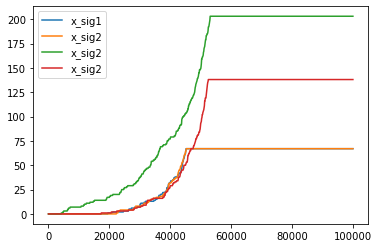

In [1401]:
for k in ['x_sig']:
    r  = make_roc(res_dfc1, k, n_max=100000, ascending=True)
    plt.plot(r[0],r[1], label=k+'1')
    r  = make_roc(res_dfc2, k, n_max=100000, ascending=True)
    plt.plot(r[0],r[1], label=k+'2')
    r  = make_roc(res_df2, k, n_max=100000, ascending=True)
    plt.plot(r[0],r[1], label=k+'2')
    r  = make_roc(res_df1, k, n_max=100000, ascending=True)
    plt.plot(r[0],r[1], label=k+'2')
plt.legend()

In [1402]:
fp1 = res_df1.loc[~res_df1['loc_idx'].isin(matches['loc_idx_tar'])]
fp2 = res_df2.loc[~res_df2['loc_idx'].isin(matches['loc_idx_pred'])]

In [1403]:
print(fp1['gene'].str.contains('Blank').sum())
print(fp2['gene'].str.contains('Blank').sum())

71
136


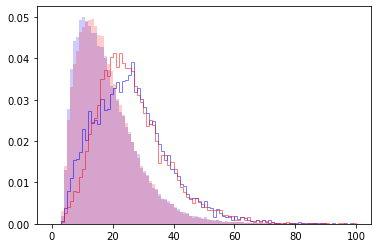

In [1404]:
_ =plt.hist(fp1['x_sig'], alpha=0.5, bins = np.linspace(0,100,101), histtype='step', color='blue', density=True)
_ =plt.hist(res_df1['x_sig'], alpha=0.2, bins = np.linspace(0,100,101), color='blue', density=True)
_ =plt.hist(fp2['x_sig'], alpha=0.5, bins = np.linspace(0,100,101), histtype='step', color='red', density=True)
_ =plt.hist(res_df2['x_sig'], alpha=0.2, bins = np.linspace(0,100,101), color='red', density=True)

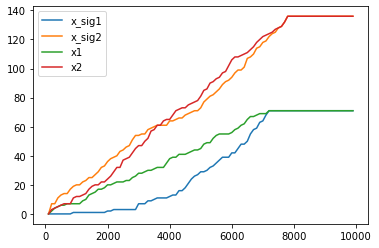

In [1405]:
for k in ['x_sig', 'x']:
    r  = make_roc(fp1, k, n_max=10000, ascending=True)
    plt.plot(r[0],r[1], label=k+'1')
    r  = make_roc(fp2, k, n_max=10000, ascending=True)
    plt.plot(r[0],r[1], label=k+'2')
plt.legend()

In [1406]:
imgvol = cpu(read_MOp_tiff(base_path+'/datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_images151.tif', scaled=True, z_to_batch=True)).max(0).max(0)[0]

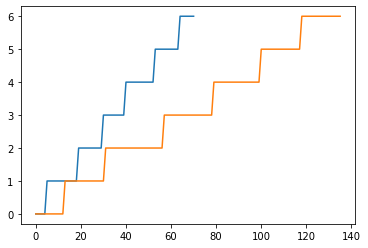

In [1431]:
plt.plot(fp1[fp1['gene'].str.contains('Blank')].nsmallest(200,'frame_idx')['frame_idx'].values)
plt.plot(fp2[fp2['gene'].str.contains('Blank')].nsmallest(200,'frame_idx')['frame_idx'].values)

(1800.0, 1900.0)

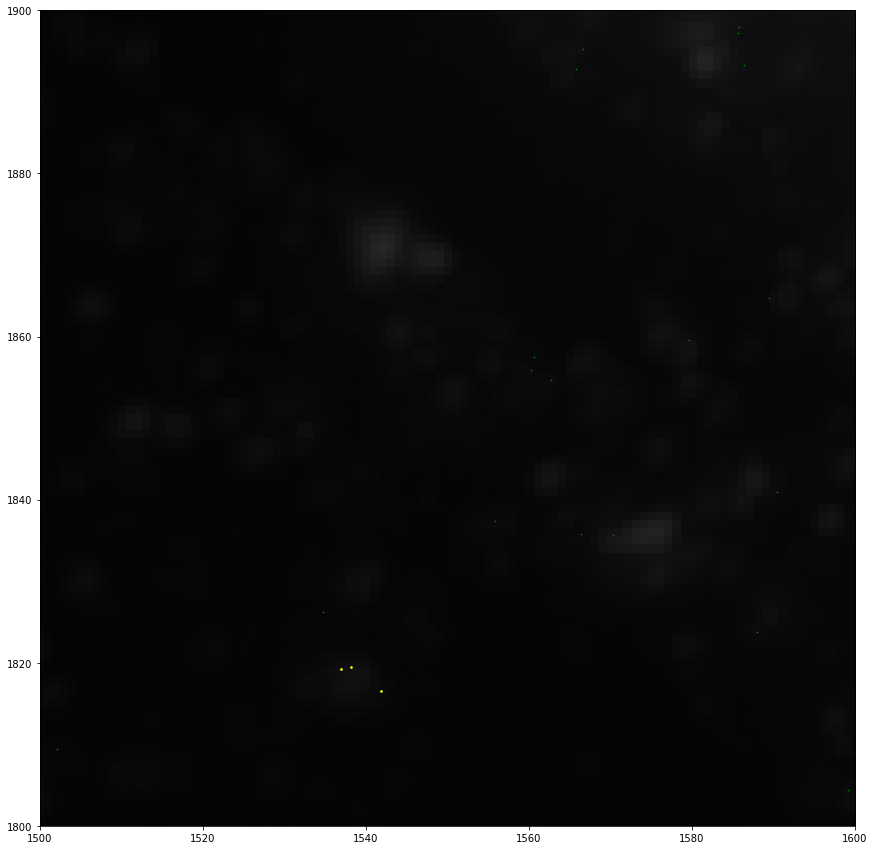

In [1435]:
plt.figure(figsize=(15,15))
plt.imshow(imgvol, cmap='gray')

# plt.scatter(nm_to_px(fp1)['x'], nm_to_px(fp1)['y'], s=0.5, color='red')
plt.scatter(nm_to_px(fp2)['x'], nm_to_px(fp2)['y'], s=0.5, color='green')
                         
plt.scatter(nm_to_px(fp1[fp1['gene'].str.contains('Blank')])['x'], nm_to_px(fp1[fp1['gene'].str.contains('Blank')])['y'], s=2.5, color='pink')
plt.scatter(nm_to_px(fp2[fp2['gene'].str.contains('Blank')])['x'], nm_to_px(fp2[fp2['gene'].str.contains('Blank')])['y'], s=2.5, color='yellow')
plt.xlim(1500,1600)
plt.ylim(1800,1900)

0.6583089515464956

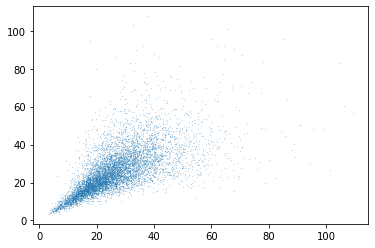

In [1387]:
plt.scatter(fp2['x_sig'], fp2['y_sig'], s=0.01)
np.corrcoef(np.array(fp2['x_sig'], dtype=np.float32), np.array(fp2['y_sig'], dtype=np.float32))[0,1]

In [1385]:
_,tra,shift = matching(fp1, fp2, tolerance=500, print_res=True, match_genes=False)

Recall: 0.138
Precision: 0.126
Jaccard: 7.059
RMSE_vol: 317.488
Eff_3d: -83.950
FN: 6187.0 FP: 6834.0
Num. matches: 989.000
Shift: 22.41,-2.98,-1.74


36405 7176


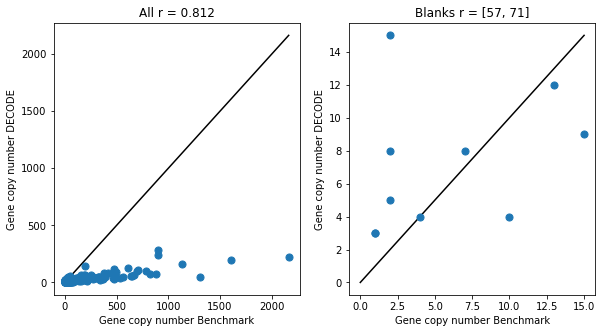

In [1422]:
plot_gene_panels(fp1.nsmallest(36405, 'comb_sig'), bench_151, targets)

36405 36405


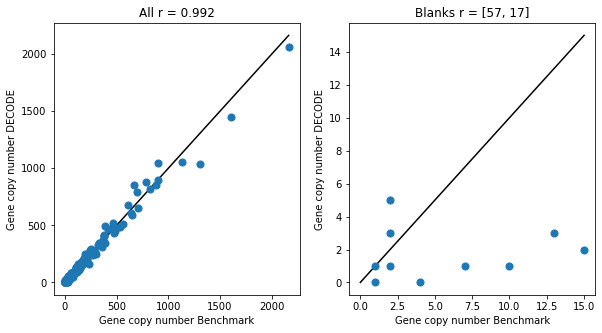

In [1243]:
plot_gene_panels(res_df1.nsmallest(36405, 'comb_sig'), bench_151, targets)

36464 36500


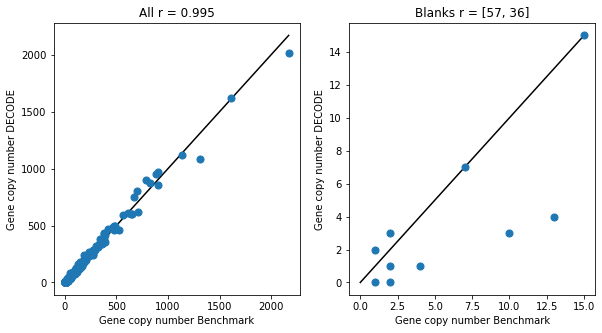

In [497]:
plot_gene_panels(istd_151.nlargest(36500, 'quality'), bench_151, targets)

In [503]:
len(targets)

252

In [997]:
fns = res_df2.loc[~res_df2['loc_idx'].isin(matches['loc_idx_tar'])]
tps = res_df2.loc[res_df2['loc_idx'].isin(matches['loc_idx_tar'])]
fps = res_df.loc[~res_df['loc_idx'].isin(matches['loc_idx_pred'])]
print(tps['gene'].str.contains('Blank').sum()/len(tps)*100)
print(fns['gene'].str.contains('Blank').sum()/len(fns)*100)
print(fps['gene'].str.contains('Blank').sum()/len(fps)*100)

0.233849751534639
0.3033268101761253
0.22388059701492538


In [1030]:
fns = istd_151.loc[~istd_151['loc_idx'].isin(matches['loc_idx_tar'])]
tps = istd_151.loc[istd_151['loc_idx'].isin(matches['loc_idx_tar'])]
fps = res_df.loc[~res_df['loc_idx'].isin(matches['loc_idx_pred'])]
print(tps['gene'].str.contains('Blank').sum()/len(tps)*100)
print(fns['gene'].str.contains('Blank').sum()/len(fns)*100)
print(fps['gene'].str.contains('Blank').sum()/len(fps)*100)

0.11387163561076605
2.4536775421586414
1.5951352780470611


In [705]:
gene_counts = DF(data=None, index=targets)
gene_counts['dec'] = res_sub_s.groupby('gene')['gene'].count()
gene_counts['ist'] = bench_df.groupby('gene')['gene'].count()
gene_counts['tps'] = tps.groupby('gene')['gene'].count()
gene_counts['fps'] = fps.groupby('gene')['gene'].count()
gene_counts['fns'] = fns.groupby('gene')['gene'].count()
gene_counts = gene_counts.fillna(0)

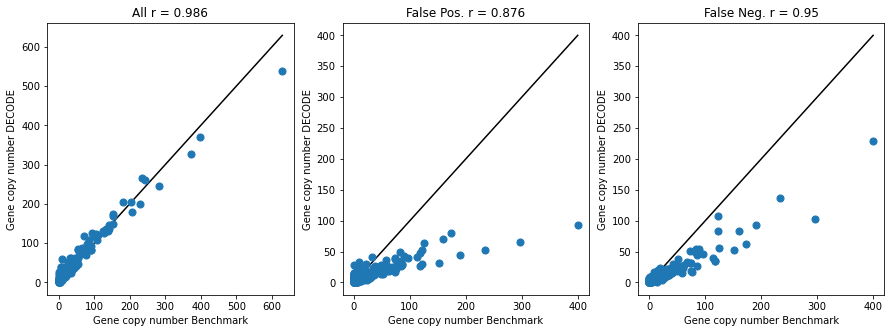

In [706]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plot_gene_numbers(gene_counts['ist'].values, gene_counts['dec'].values, 'All', log=False)
plt.subplot(132)
plot_gene_numbers(gene_counts['tps'].values, gene_counts['fps'].values, 'False Pos.', log=False)
plt.subplot(133)
plot_gene_numbers(gene_counts['tps'].values, gene_counts['fns'].values, 'False Neg.', log=False)

Text(0.5, 1.0, 'Corr. 0.954')

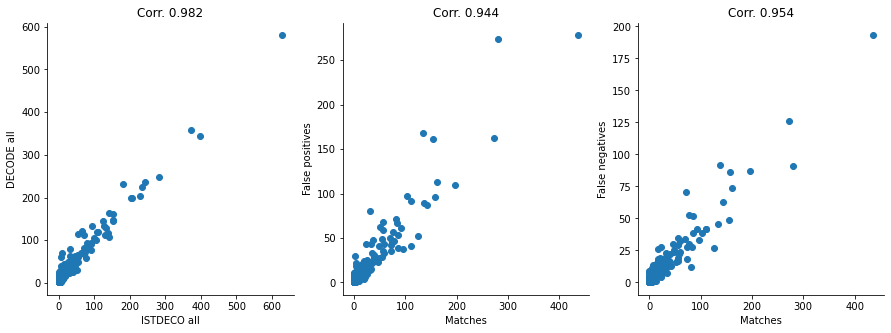

In [676]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(gene_counts['ist'].values, gene_counts['dec'].values)
plt.plot([0,0],[len(gene_counts['ist'].values),len(gene_counts['dec'].values)])
sns.despine()
plt.xlabel('ISTDECO all')
plt.ylabel('DECODE all')
plt.title('Corr. ' + str(np.corrcoef(gene_counts['ist'].values, gene_counts['dec'].values)[0,1])[:5])
plt.subplot(132)
plt.scatter(gene_counts['tps'].values, gene_counts['fps'].values)
sns.despine()
plt.xlabel('Matches')
plt.ylabel('False positives')
plt.title('Corr. ' + str(np.corrcoef(gene_counts['tps'].values, gene_counts['fps'].values)[0,1])[:5])
plt.subplot(133)
plt.scatter(gene_counts['tps'].values, gene_counts['fns'].values)
sns.despine()
plt.xlabel('Matches')
plt.ylabel('False negatives')
plt.title('Corr. ' + str(np.corrcoef(gene_counts['tps'].values, gene_counts['fns'].values)[0,1])[:5])


In [372]:
par_dict = {}
par_dict['istdeco'] = [istd_151, 'quality', False]
for i,k in enumerate(df_dict['151']):
#     if 'dec_' in k and '151' in k:
    if len(df_dict['151'][k]) > 0:
        tra = sel_int_ch(df_dict['151'][k], codebook)
        par_dict[k] = [tra, 'int_ratio', True]
    #         par_dict[k+'_s'] = [remove_doublets(df_dict[k].nsmallest(50000,'comb_sig')), 'comb_sig', True]

roc_dict = {}
for k in par_dict:
    x, y = make_roc(*par_dict[k], n_max=80000)
    roc_dict[k] = [x, y]

In [373]:
df = pd.DataFrame(columns=roc_dict.keys())
df['x'] = roc_dict[df.keys()[0]][0]
for k in roc_dict.keys():
    df[k] = roc_dict[k][1]

In [374]:
len(bench_151)

36405

In [375]:
fig = px.line(df, x="x", y=list(roc_dict.keys()), range_y=[0,100], range_x=[0,60000], labels={"x": "Number genes","value":'Number blanks'})
fig.show()

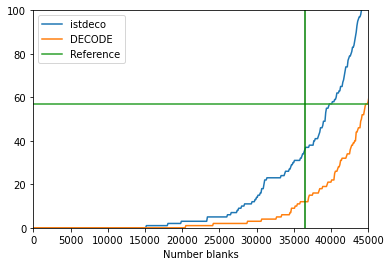

In [377]:
plt.plot(df['x'], df['istdeco'], label='istdeco')
plt.plot(df['x'], df['_no_foci'], label='DECODE')
plt.plot([0,45000], [57,57], label='Reference')
plt.plot([36500,36500], [0,100], color='green')
plt.xlim(0,45000)
plt.ylim(0,100)
plt.xlabel('Number transcripts')
plt.xlabel('Number blanks')
plt.legend()

In [972]:
df_dict['47'].keys()

dict_keys(['_num_iters:9995xz_sig_fac:1.0xmodel_init:null', '_norm:nonexl1_reg:0.001', '_num_iters:9995xscale:300xmodel_init:null', '_schedule:nullxfreq:3xnorm:none', '_norm:nonextheta_par:Truexconst_theta_sim:False', '_norm:escortxl1_reg:0.001', '_norm:escortxl1_reg:0.0001', '_num_iters:9995xscale:400xmodel_init:null', '_norm:nonexmean_diff:True', '_schedule:nullxfreq:5xnorm:none', '_norm:none', '_norm:nonexl1_reg:0.0', '_norm:escort', '_schedule:nullxfreq:1xnorm:none', '_norm:escortxl1_reg:0.0', '_norm:nonexl1_reg:0.0001', '_num_iters:9995xphasing:0.15xmodel_init:null'])

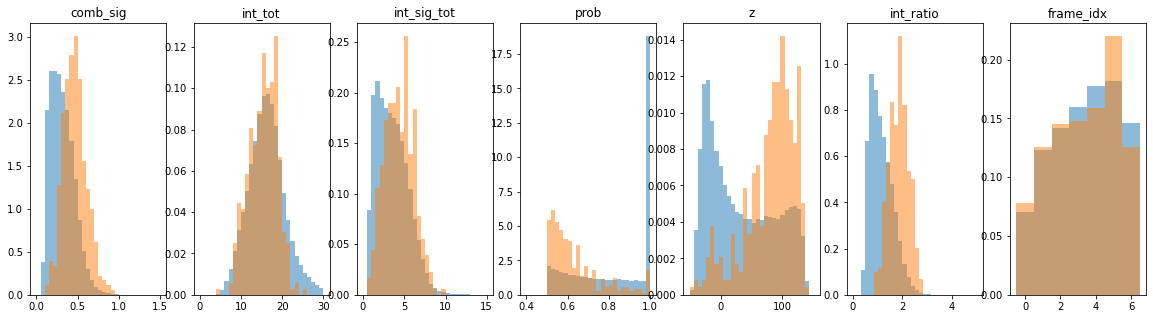

In [82]:
res_df = df_dict['47']['_scale:500']
res_df = sel_int_ch(res_df, codebook)
int_m = [f'int_{i}' for i in range(4)]
int_s = [f'int_sig_{i}' for i in range(4)]
res_df['int_tot'] = res_df.loc[:,int_m].values.sum(-1)
res_df['int_sig_tot'] = res_df.loc[:,int_s].values.sum(-1)


metrics = ['comb_sig','int_tot','int_sig_tot', 'prob','z','int_ratio','frame_idx']
bins = [np.linspace(0,1.5,31), np.linspace(0,30,31), np.linspace(0,15,31), np.linspace(0.4,1,31), np.linspace(-50,150.,31), np.linspace(0,5.,31), np.linspace(-0.5,6.5,8)]
plt.figure(figsize=(20,5))
for i in range(len(metrics)):
    plt.subplot(1,len(metrics),i+1)
    _=plt.hist(res_df[~res_df['gene'].str.contains('Blank')][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='gene matches')
    _=plt.hist(res_df[res_df['gene'].str.contains('Blank')][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='blank matches')
    plt.title(metrics[i])

In [81]:
np.linspace(-0.5,6.5,8)

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5])

In [74]:
res_df = df_dict['47']['_count_mult:0.01']
# res_df = sel_int_ch(res_df, codebook)
int_m = [f'int_{i}' for i in range(4)]
int_s = [f'int_sig_{i}' for i in range(4)]
res_df['int_tot'] = res_df.loc[:,int_m].values.sum(-1)
res_df['int_sig_tot'] = res_df.loc[:,int_s].values.sum(-1)


metrics = ['comb_sig','int_tot','int_sig_tot', 'prob','z','int_ratio']
bins = [np.linspace(0,1.5,31), np.linspace(0,30,31), np.linspace(0,15,31), np.linspace(0.4,1,31), np.linspace(-50,150.,31), np.linspace(0,2.,31)]
plt.figure(figsize=(20,5))
for i in range(len(metrics)):
    plt.subplot(1,len(metrics),i+1)
    _=plt.hist(res_df[~res_df['gene'].str.contains('Blank')][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='gene matches')
    _=plt.hist(res_df[res_df['gene'].str.contains('Blank')][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='blank matches')
    plt.title(metrics[i])

KeyError: '_count_mult:0.01'

In [1012]:
def corr_scatter(v1, v2, s=0.3):
    plt.scatter(v1, v2, s=s)
    plt.title(np.corrcoef(v1, v2)[0,1])

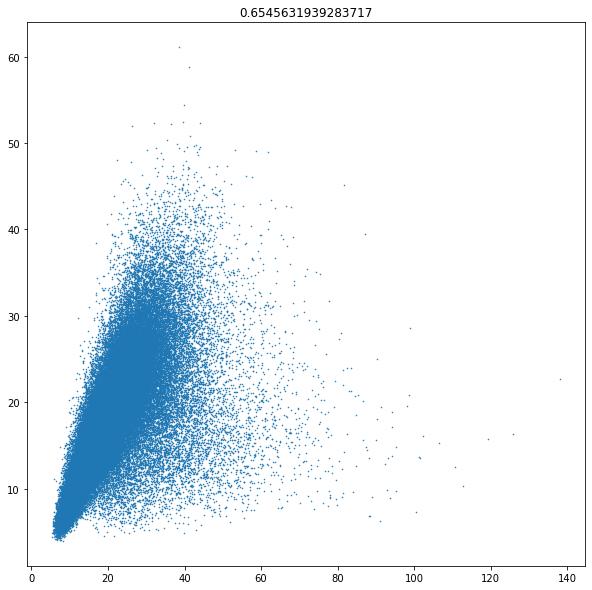

In [1041]:
plt.figure(figsize=(10,10))

corr_scatter(res_df['x_sig'], res_df['z_sig'])

In [299]:
res_df = df_dict['dec_enabled:Truexint_inf:per_channelxchannel_shifts:Truexchannel_facs:Truexn_foci_avg:1xseed:2'].nsmallest(10000, 'comb_sig')

In [290]:
code_cols = [plt.get_cmap('gist_ncar')(x) for x in np.linspace(0.,1.,140)]

In [291]:
import mpld3
from mpld3 import plugins

In [663]:
res_sub = df_dict['dec_psf_noise:0.0xrate_fac:3.0'].nsmallest(17000, 'comb_sig')
# res_sub = df_dict['dec_min_int_sig:0.0xint_fac:0.1'].nsmallest(15000, 'code_err')
ist_sub = istdeco_df.nlargest(15000, 'quality')
bench_sub = bench_df.nlargest(13800, 'total_magnitude')

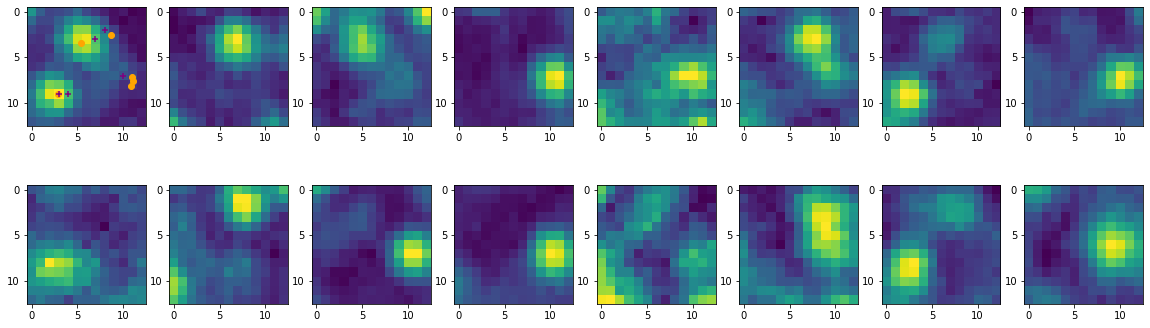

In [664]:
vol, crop = extract_roi(img_stack[None], torch.IntTensor([514,740,0]), 6, 8)

res_crop = crop_df(nm_to_px(res_sub), crop)
ist_crop = crop_df(nm_to_px(ist_sub), crop)

plt.figure(figsize=(20,6))
for i in range(16):
    plt.subplot(2,8,i+1)
    plt.imshow(vol[0,i])
    
    if not i:
        plt.scatter(res_crop['x'],res_crop['y'],color='orange')
        plt.scatter(ist_crop['x'],ist_crop['y'],color='purple', marker='+')

In [80]:
img_stack = read_MOp_tiff(base_path+'/datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_images47.tif')[:,:,:,:,:]

In [81]:
img_stack.shape

torch.Size([1, 22, 7, 2048, 2048])

In [82]:
from decode_fish.funcs.dataset import GaussianSmoothing
filt = GaussianSmoothing(11, device='cpu')
img_filt = filt(img_stack)
img_stack -= img_filt

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [971]:
df_dict['47'].keys()

dict_keys(['_num_iters:9995xz_sig_fac:1.0xmodel_init:null', '_norm:nonexl1_reg:0.001', '_num_iters:9995xscale:300xmodel_init:null', '_schedule:nullxfreq:3xnorm:none', '_norm:nonextheta_par:Truexconst_theta_sim:False', '_norm:escortxl1_reg:0.001', '_norm:escortxl1_reg:0.0001', '_num_iters:9995xscale:400xmodel_init:null', '_norm:nonexmean_diff:True', '_schedule:nullxfreq:5xnorm:none', '_norm:none', '_norm:nonexl1_reg:0.0', '_norm:escort', '_schedule:nullxfreq:1xnorm:none', '_norm:escortxl1_reg:0.0', '_norm:nonexl1_reg:0.0001', '_num_iters:9995xphasing:0.15xmodel_init:null'])

In [1116]:
res_df = df_dict['47']['_norm:nonexmean_diff:True'].nsmallest(40000, 'score')
ints = res_df[[f'int_{i}' for i in range(22)]].values
ints[code_ref[res_df['code_inds'].values]==0] = 0.

In [1117]:
def extract_roi(beads: torch.Tensor, coordinates, size_xy=5):
    res = []
    
    x, y, z = coordinates
    crop = np.s_[:,z, int(y-size_xy): int(y+size_xy+1), int(x-size_xy): int(x+size_xy+1)]
    single_bead = beads[crop]
        
    return single_bead, crop

In [1118]:
z_vols = [[] for _ in range(20)]

In [1119]:
int_keys = [f'int_{i}' for i in range(22)]

In [1120]:
for i in tqdm(range(len(res_df))):
    b_loc = nm_to_px(res_df.iloc[i])
    vol, crop = extract_roi(img_stack[0], torch.IntTensor(np.array(b_loc.loc[['x','y','frame_idx']].values, dtype='float32')), 6)
    if vol.shape == torch.Size([22, 13, 13]):
        ints = b_loc[int_keys].values.astype('float32')
        volm = vol/ints[:,None,None]
        volm = cpu(volm[code_ref[b_loc['code_inds']].nonzero()[0]])
        z = (100*b_loc['z'] + 50)/2
        z_vols[int(z/5)].append(volm)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40000/40000 [01:26<00:00, 463.36it/s]


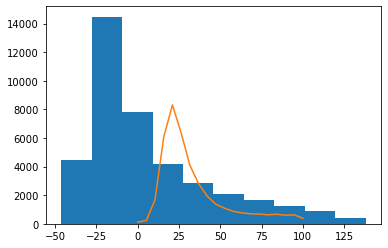

In [1068]:
plt.hist(res_df['z'], bins=np.linspace(0,100,20))
plt.plot(np.linspace(0,100,20), [len(z) for z in z_volspn])

In [1092]:
def get_psf_vol(stack):
    psf_vol = []
    for i in range(len(stack)):
        if len(stack[i]):
            mvol = np.concatenate(stack[i])
            mvol = mvol.reshape(-1, mvol.shape[-2], mvol.shape[-1])
            psf_vol.append(mvol.mean(0))
    return np.stack(psf_vol)

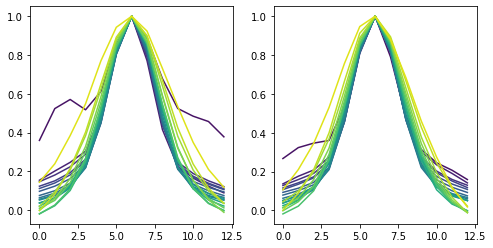

In [1114]:
import seaborn as sns
cpal = sns.color_palette("viridis", n_colors=20)
plt.figure(figsize=(8,4))
plt.subplot(121)
for i in range(len(pltvol)):
    plt.plot(pltvol[i][6, :]/pltvol[i][6, :].max(), color=cpal[i])
plt.subplot(122)
for i in range(len(pltvol)):
    plt.plot(pltvol[i][:, 6]/pltvol[i][:, 6].max(), color=cpal[i])

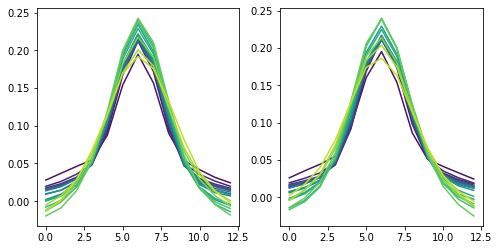

In [1126]:
import seaborn as sns
cpal = sns.color_palette("viridis", n_colors=20)
plt.figure(figsize=(8,4))
plt.subplot(121)
for i in range(len(pltvol)):
    plt.plot(pltvol[i][6, :]/pltvol[i][6, :].sum(), color=cpal[i])
plt.subplot(122)
for i in range(len(pltvol)):
    plt.plot(pltvol[i][:, 6]/pltvol[i][:, 6].sum(), color=cpal[i])

(<Figure size 1106.58x1063.38 with 6 Axes>,
 [<AxesSubplot:ylabel='y'>,
  <AxesSubplot:xlabel='x', ylabel='z'>,
  <AxesSubplot:xlabel='z'>])

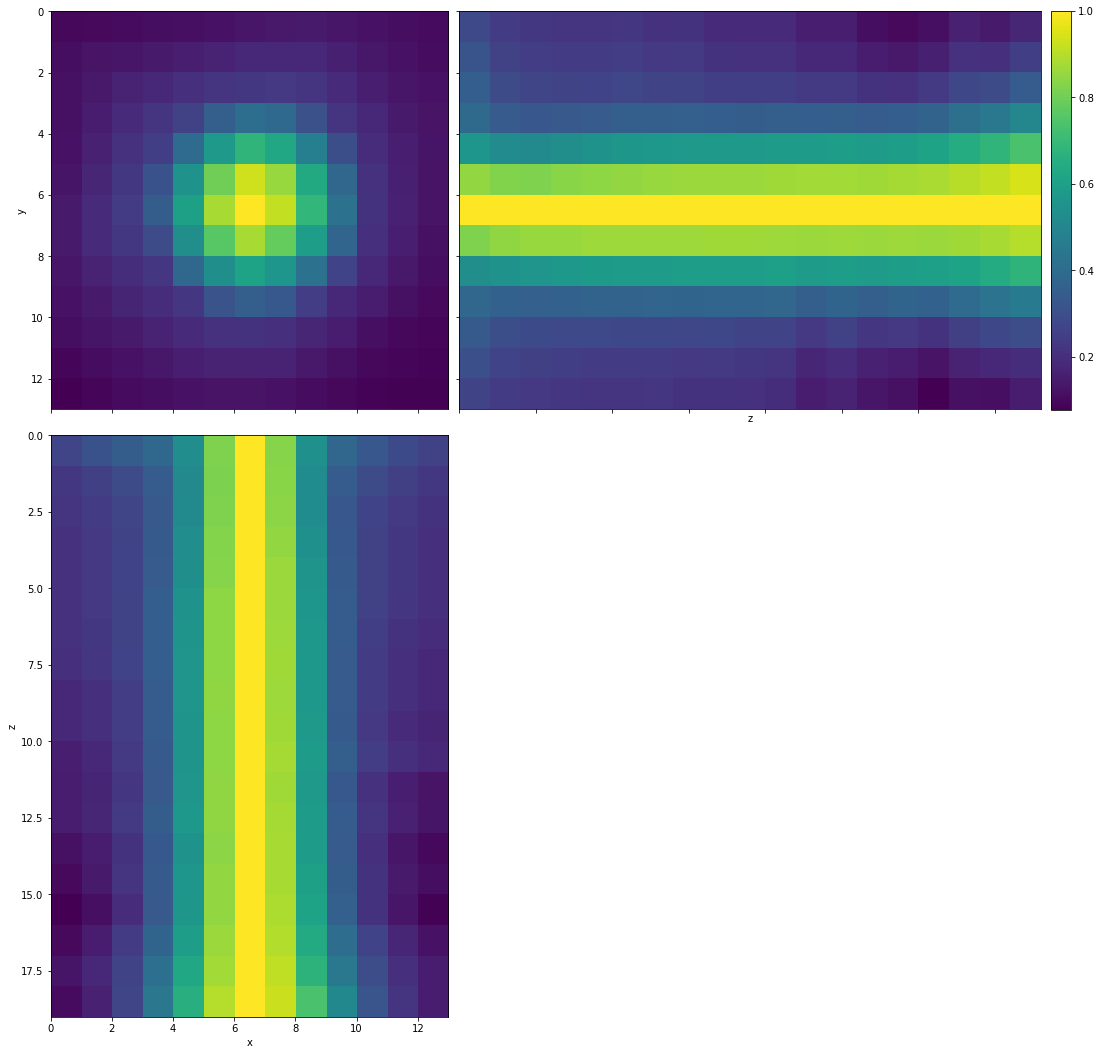

In [1121]:
pltvol = get_psf_vol(z_vols)
# plot_3d_projections(pltvol/pltvol.max(-1).max(-1)[...,None,None])

21392


(600.0, 750.0)

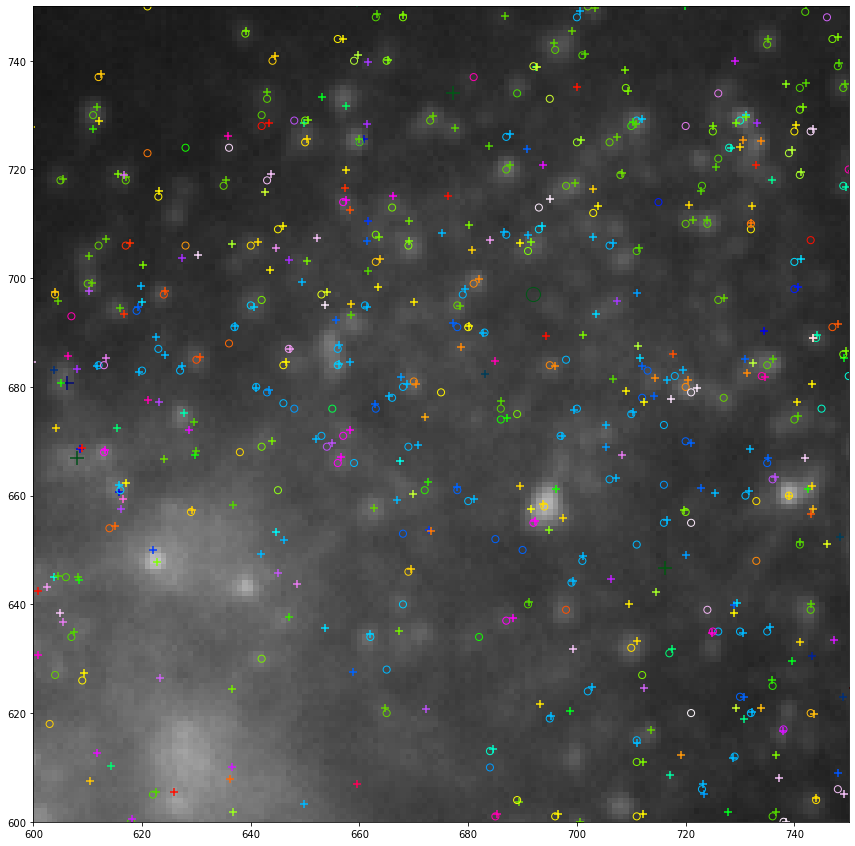

In [63]:
ind = 0
img = load_tiff_image(image_paths[ind])
preds_px = nm_to_px(res_single)#[res_df['gene']!='MALAT1']
bench_px = nm_to_px(ist_sub)#[bench_df['gene']!='MALAT1']
print(len(preds_px))
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(img[0,0], cmap='gray')

for i in range(len(targets)):
    
    preds_sub = preds_px[preds_px['code_inds'] == i]
    bench_sub = bench_px[bench_px['code_inds'] == i]
    
    size = 200. if 'Blank' in targets[i] else 50.

    ax.scatter(bench_sub['x'],bench_sub['y'], color=code_cols[i], s=size, marker='o', facecolor='none')
    ax.scatter(preds_sub['x'],preds_sub['y'], color=code_cols[i], s=size, marker='+')

ax.set_xlim(600,750)
ax.set_ylim(600,750)

# plugins.connect(fig, plugins.MousePosition(fontsize=14))
# mpld3.display()

In [409]:
def extract_roi(beads: torch.Tensor, coordinates, size_xy=5, size_z=10):
    res = []
    
    x, y, z = coordinates
    crop = np.s_[:,int(z):int(z+1), int(y-size_xy): int(y+size_xy+1), int(x-size_xy): int(x+size_xy+1)]
    single_bead = beads[crop]
        
    return single_bead, crop

# Analyze blanks

26


,loc_idx,frame_idx,code_inds,x,y,z,prob,x_sig,y_sig,z_sig,...,int_1,int_2,int_3,int_sig_0,int_sig_1,int_sig_2,int_sig_3,zm,int_tot,int_sig_tot
28421,28421,0,243,383.26723,68.88303,2.376363,0.658758,17.744606,23.340118,8.481233,...,5.209935,6.694495,8.023641,1.996939,1.568243,3.390814,3.319344,37.63626,26.435554,10.275341


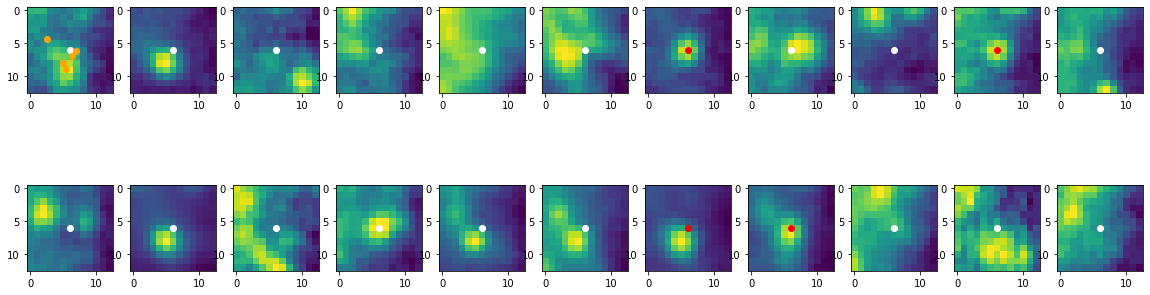

In [422]:
# Random predictions 
res_sub = res_df.nsmallest(20000, 'comb_sig')
# Random blank 
sub = res_sub[res_sub['gene'].str.contains('Blank')]

ind = np.random.randint(0, len(sub))
print(ind)

b_loc = nm_to_px(sub.iloc[ind])
display(DF(b_loc).T)
vol, crop = extract_roi(img_stack, torch.IntTensor(np.array(b_loc.loc[['x','y','z']].values, dtype='float32')), 6, 8)

res_crop = crop_df(nm_to_px(res_sub), crop)
bench_crop = crop_df(nm_to_px(bench_df), crop)

plt.figure(figsize=(20,6))
for i in range(22):
    plt.subplot(2,11,i+1)
    plt.imshow(vol[i,0])
    color = 'red' if code_ref[list(targets).index(b_loc['gene'])][i] else 'white'
    plt.scatter([6],[6], color=color)
    
#     plt.title(str(np.round(b_loc[f'int_{i}'], 3)) + ' +- ' + str(np.round(b_loc[f'int_sig_{i}'], 3)))
    
    if not i:
        plt.scatter(res_crop['x'],res_crop['y'],color='orange')
        plt.scatter(bench_crop['x'],bench_crop['y'],color='purple', marker='+')

In [677]:
fn_inds = fns['loc_idx'].values

In [678]:
len(res_df)

15020

In [679]:
res_sub = res_df.nsmallest(10000, 'comb_sig')

,loc_idx,x,y,z,gene,frame_idx,code_inds
5894569,5894569,90.023502,729.022581,2.304147,Pdgfc,0,152


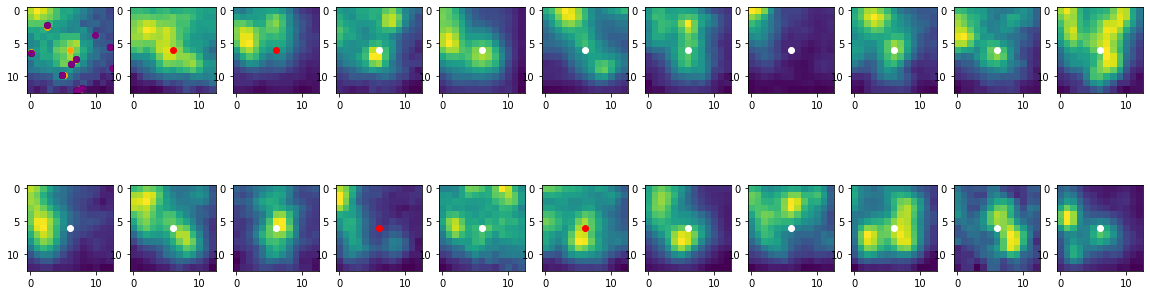

In [681]:
ind = np.random.randint(0, len(fn_inds))
ind = fn_inds[ind]

b_loc = nm_to_px(bench_df[bench_df['loc_idx'] == ind], px_size_zyx=[120.0, 100.0, 100.0]).iloc[0]

display(DF(b_loc).T)
vol, crop = extract_roi(img_stack, torch.IntTensor(np.array(b_loc.loc[['x','y','z']].values, dtype='float32')), 6, 8)

cropb = crop_df(nm_to_px(bench_df, px_size_zyx=[120.0, 100.0, 100.0]), crop)
cropr = crop_df(nm_to_px(res_sub), crop)
cropf = crop_df(nm_to_px(res_df), crop)

plt.figure(figsize=(20,6))
for i in range(22):
    plt.subplot(2,11,i+1)
    plt.imshow(vol[i,0])
    color = 'red' if code_ref[list(targets).index(b_loc['gene'])][i] else 'white'
    plt.scatter([6],[6], color=color)
    
    if not i:
        plt.scatter(cropb['x'],cropb['y'],color='orange')
        plt.scatter(cropr['x'],cropr['y'],color='black')
        plt.scatter(cropf['x'],cropf['y'],color='purple')

In [545]:
cropb

,loc_idx,x,y,z,gene,frame_idx,code_inds
5911774,5911774,6.497235,6.030876,0.760369,Olfm3,0,144


In [382]:
res_df = remove_doublets(df_dict['dec_num_iters:100000xenabled:False'])

In [383]:
keys = ['x_sig','y_sig','z_sig','prob','int_0', 'int_1', 'int_2', 'int_3', 'int_sig_0', 'int_sig_1', 'int_sig_2', 'int_sig_3', 'zm']
res_df['class'] = res_df['gene'].str.contains('Blank')*1

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [384]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

X = np.concatenate([res_df.nsmallest(10000,'comb_sig')[keys].values, res_df[res_df['class'] == 1][keys].values])
y = np.concatenate([res_df.nsmallest(10000,'comb_sig')['class'].values, res_df[res_df['class'] == 1]['class'].values])
 
clf = LogisticRegression(random_state=0,max_iter=10000).fit(X, y)

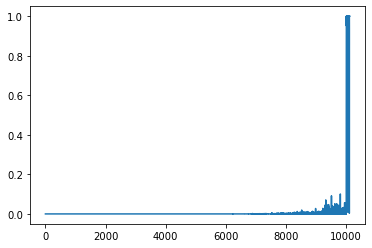

In [385]:
plt.plot(clf.predict_proba(X)[:,1])

In [386]:
# res_df = remove_doublets(df_dict['dec_num_iters:100000xenabled:False'])
res_df = remove_doublets(df_dict['dec_start_mic:30000xpsf_vol:Truextheta_par:Truexlr:0.0004'])
X = res_df[keys]

In [387]:
res_df['score'] = clf.predict_proba(X)[:,1]

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



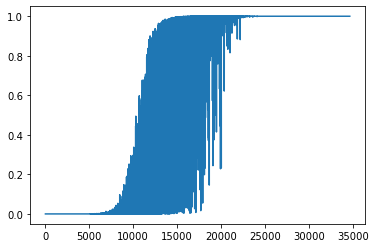

In [388]:
plt.plot(res_df.nsmallest(50000, 'comb_sig')['score'].values)

In [61]:
df_dict['47'].keys()

dict_keys(['_scale:500', '_scale:800', '_scale:700', '_scale:600'])

In [66]:
res_df1 = df_dict['47']['_scale:500']
res_df2 = df_dict['151']['_scale:500']

res_df1 = sel_int_ch(res_df1, codebook)
res_df2 = sel_int_ch(res_df2, codebook)

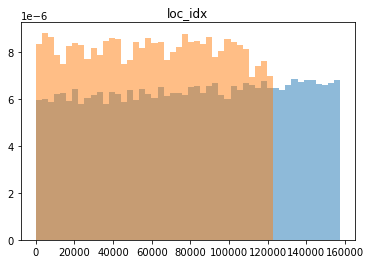

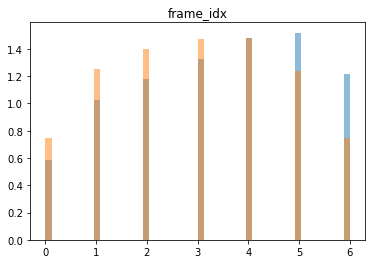

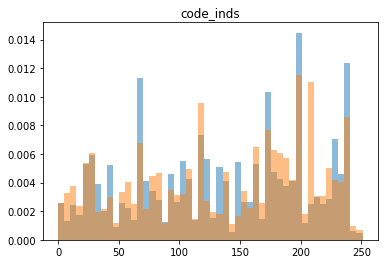

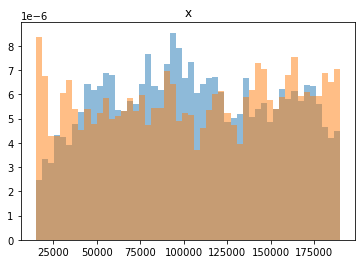

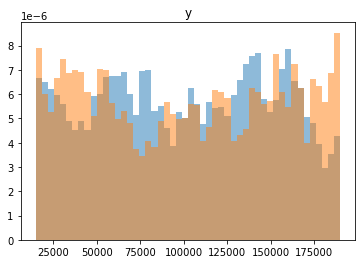

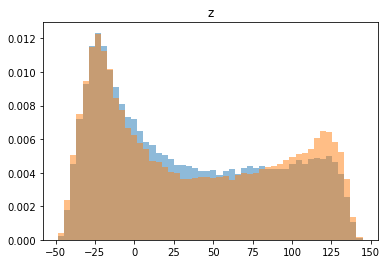

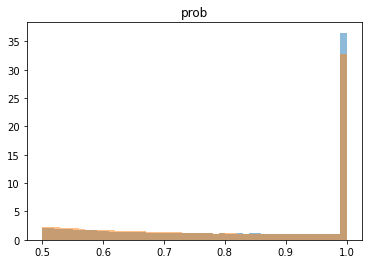

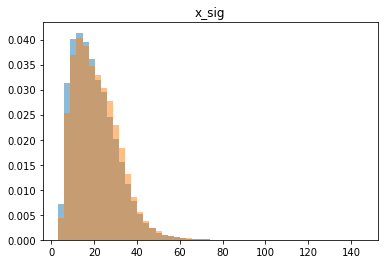

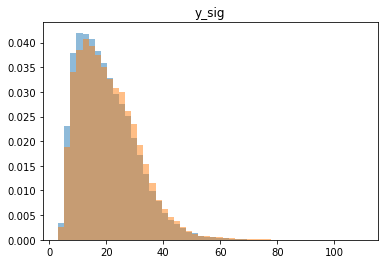

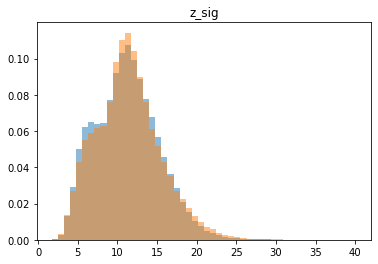

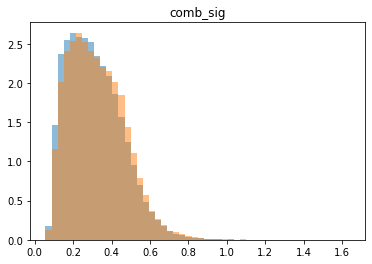

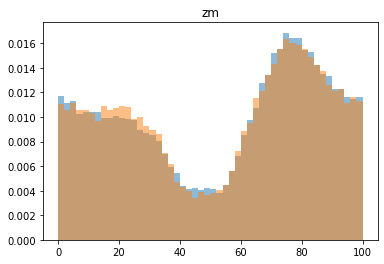

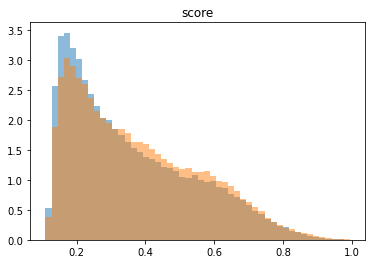

<__array_function__ internals>:5: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.



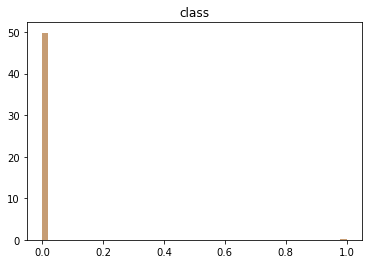

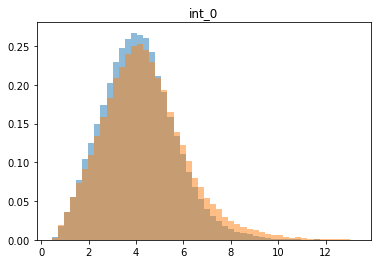

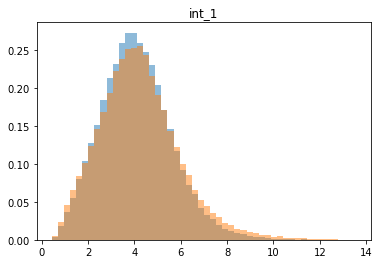

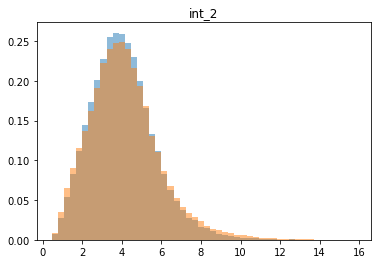

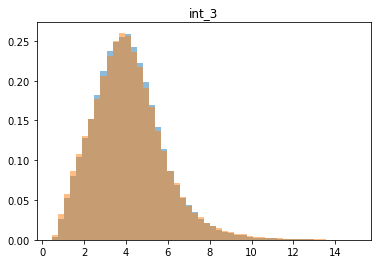

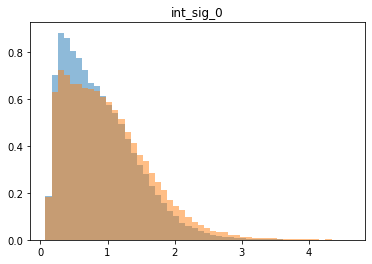

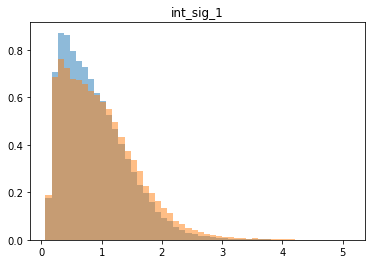

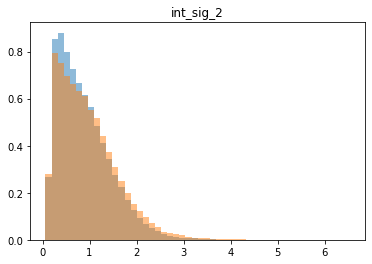

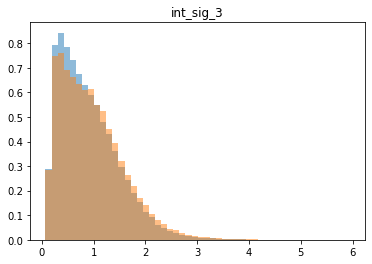

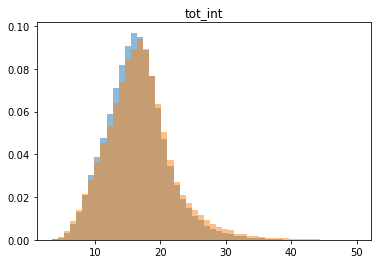

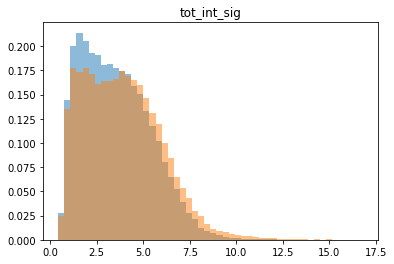

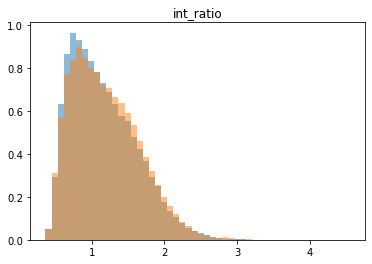

In [72]:
for k in res_df1.keys():
    if 'gene' not in k:
# for k in ['x_sig', 'y_sig', 'z', 'z_sig']:
        bins = np.linspace(res_df1[k].min(), res_df1[k].max(), 51)
        plt.hist(res_df1[k], alpha=0.5, bins=bins, density=True)
        plt.hist(res_df2[k], alpha=0.5, bins=bins, density=True)
        plt.title(k)
        plt.show()